## Data loading - YLFW Benchmark
Source: https://github.com/JessyFrish/YLFW_Links?tab=readme-ov-file

Make suitable for ArcFace and MagFace (112x112) and FaceNet (160x160)

### Data folder structure and metadata


In [3]:
# Load packages

# Common
import pandas as pd
import numpy as np
import os
import cv2 as cv
from IPython.display import clear_output as cls
import json

# Data
from glob import glob

# Data Visuaalization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()


### Descriptive analysis of data

#### Data concatenation

In [4]:
## Create dataframe

# Define the path to the raw data directory
raw_data_path = '../data/raw_full/'

# Initialize lists to store image characteristics
img_names = []
id_class = []
ethnicities = []

# Iterate through the directories of each ethnicity (e.g., 'Asian')
ethnicities_list = os.listdir(raw_data_path + 'YLFW/data_aligned')
#To ensure DS Store is not included. DELETE files with '.'
ethnicities_list = [x for x in ethnicities_list if not x.startswith(".")]

for ethnicity in ethnicities_list:
    ethnicity_col = ethnicity.split('_')[0]
    id = int(ethnicity.split('_')[1:][0])
    ethnicity_dir = os.path.join(raw_data_path + 'YLFW/data_aligned', ethnicity)
    if os.path.isdir(ethnicity_dir):
        # Iterate through image files in the ethnicity directory
        for img_name in os.listdir(ethnicity_dir):
            # Append image characteristics to lists
            img_name = img_name.split('.')[0]
            img_names.append(img_name)
            ethnicities.append(ethnicity_col)


# Create a DataFrame from the lists
data = {'image_name': img_names, 'ethnicity': ethnicities}
df = pd.DataFrame(data)

# Display the DataFrame
print("len of df", len(df))
print("\nisna?", df.isna().sum())
df.head()


len of df 9810

isna? image_name    0
ethnicity     0
dtype: int64


,image_name,ethnicity
0,African_0_0,African
1,African_0_1,African
2,African_1_11,African
3,African_1_4,African
4,African_10_1,African


In [5]:
# Read the JSON file into a JSON variable
with open('/mnt/c/Dokumenter/Dokumenter/UNI/Master/Thesis/GitHub_Repo/Master_Thesis/data/age_estimations/YLFW_output_data_precroped_all_age.json', 'r') as file:
    json_data = json.load(file)

# Convert the JSON data to a DataFrame
age_df = pd.DataFrame.from_dict(json_data, orient='index', columns=['Age'])
# Convert the 'Age' column to numeric
age_df['Age'] = pd.to_numeric(age_df['Age'])
age_df.reset_index(inplace=True)
age_df.columns = ['image_name', 'Age']

print("len of age df",len(age_df))
print("isna", age_df.isna().sum())
age_df.head()


len of age df 9810
isna image_name      0
Age           581
dtype: int64


,image_name,Age
0,Caucasian_1008_18,8.0
1,Asian_225_72,11.0
2,Asian_238_1,3.0
3,Caucasian_1110_17,4.0
4,Caucasian_364_12,2.0


In [6]:
# Concatenate dataframes
final_df = pd.merge(age_df, df, on='image_name', how='inner')
print("len of final df",len(final_df))
print("isna?",final_df.isna().sum())
final_df.head()

len of final df 9810
isna? image_name      0
Age           581
ethnicity       0
dtype: int64


,image_name,Age,ethnicity
0,Caucasian_1008_18,8.0,Caucasian
1,Asian_225_72,11.0,Asian
2,Asian_238_1,3.0,Asian
3,Caucasian_1110_17,4.0,Caucasian
4,Caucasian_364_12,2.0,Caucasian


In [7]:
#duplicates?
final_df["image_name"].duplicated().sum()

0

In [8]:
final_df.duplicated().sum()

0

In [9]:
age_df.isna().sum()

image_name      0
Age           581
dtype: int64

In [10]:
isna_age = final_df[final_df.Age.isna()]

Relatively balanced with Caucasian being the most represented - We remove

In [11]:
isna_age.ethnicity.value_counts(normalize=True)

Caucasian    0.376936
African      0.237522
Asian        0.234079
Indian       0.151463
Name: ethnicity, dtype: float64

In [12]:
final_df.ethnicity.value_counts(normalize=True)

Caucasian    0.285525
Asian        0.268705
African      0.234251
Indian       0.211519
Name: ethnicity, dtype: float64

In [13]:
# Remove NaN values
final_df.dropna(inplace=True)
print("len of final df",len(final_df))

len of final df 9229


In [14]:
# Ensure 'Age' is of type integer
final_df['Age'] = final_df['Age'].astype(int)

# Define the age groups and corresponding labels
age_bins = [0, 4, 7, 10, 13, 16, 19]  # adding one more bin for 16-18
age_labels = ['0-3', '4-6', '7-9', '10-12', '13-15', '16-18']

# Update the DataFrame with age groupings
final_df['children_agegroup'] = pd.cut(final_df['Age'], bins=age_bins, labels=age_labels, right=False)


In [15]:
final_df.head()

,image_name,Age,ethnicity,children_agegroup
0,Caucasian_1008_18,8,Caucasian,7-9
1,Asian_225_72,11,Asian,10-12
2,Asian_238_1,3,Asian,0-3
3,Caucasian_1110_17,4,Caucasian,4-6
4,Caucasian_364_12,2,Caucasian,0-3


#### Data distributions
(Evt efter age groups)

In [16]:
plt.hist(final_df['Age'], color='skyblue')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Age Distribution')
plt.show()


KeyboardInterrupt: 

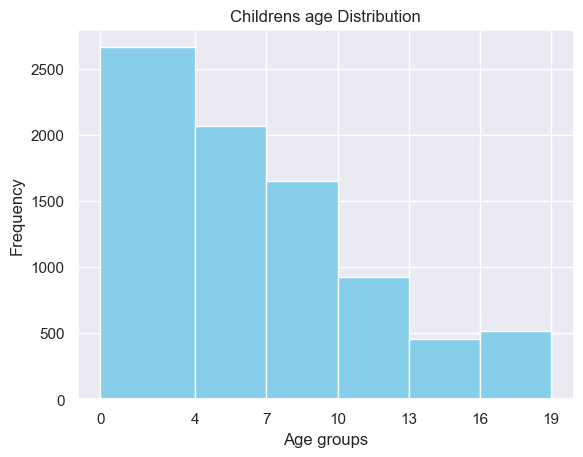

In [ ]:
# Define bin edges for each group of 3 years
bin_edges = [0, 4, 7, 10, 13, 16, 19]
plt.hist(final_df['Age'], bins=age_bins, color='skyblue')
plt.xticks(bin_edges)
plt.xlabel('Age groups')
plt.ylabel('Frequency')
plt.title('Childrens age Distribution')
plt.show()


In [41]:
# Define bin edges for each group of 3 years
plt.hist(final_df['ethnicity'], bins=4, color='skyblue')
plt.xticks(final_df['ethnicity'])
plt.xlabel('Ethnicity')
plt.ylabel('Frequency')
plt.title('Ethnicity composition')
plt.show()


KeyboardInterrupt: 

#### Save df

In [ ]:
final_df["identity_name"] = final_df["image_name"].apply(lambda x: "_".join(x.split("_")[:2]))
final_df

,image_name,Age,ethnicity,children_agegroup,identity_name
0,Caucasian_1008_18,8,Caucasian,7-9,Caucasian_1008
1,Asian_225_72,11,Asian,10-12,Asian_225
2,Asian_238_1,3,Asian,0-3,Asian_238
3,Caucasian_1110_17,4,Caucasian,4-6,Caucasian_1110
4,Caucasian_364_12,2,Caucasian,0-3,Caucasian_364
...,...,...,...,...,...
9802,Indian_132_0,11,Indian,10-12,Indian_132
9805,Caucasian_367_13,8,Caucasian,7-9,Caucasian_367
9806,Asian_19_28,29,Asian,NaN,Asian_19
9807,Asian_554_5,3,Asian,0-3,Asian_554


In [16]:
## Only run when you want to create new csv
#final_df.to_csv('../data/raw_full/YLFW_full_info_excluding_adults.csv', index=False)

#### Concatenate with children age groups from adults data

In [20]:
final_df = pd.read_csv('../data/image_info_csvs/YLFW_full_info_excluding_adults.csv')

In [25]:
final_df

,image_name,Age,ethnicity,children_agegroup,identity_name
0,Caucasian_1008_18,8,Caucasian,7-9,Caucasian_1008
1,Asian_225_72,11,Asian,10-12,Asian_225
2,Asian_238_1,3,Asian,0-3,Asian_238
3,Caucasian_1110_17,4,Caucasian,4-6,Caucasian_1110
4,Caucasian_364_12,2,Caucasian,0-3,Caucasian_364
...,...,...,...,...,...
9224,Indian_132_0,11,Indian,10-12,Indian_132
9225,Caucasian_367_13,8,Caucasian,7-9,Caucasian_367
9226,Asian_19_28,29,Asian,NaN,Asian_19
9227,Asian_554_5,3,Asian,0-3,Asian_554


In [21]:
a_df = pd.read_csv('/mnt/c/Dokumenter/Dokumenter/UNI/Master/Thesis/GitHub_Repo/Master_Thesis/data/image_info_csvs/RFW_full_info_including_children.csv')

In [22]:
a_df

,image_name,identity_name,ethnicity,Age,children_agegroup
0,m.010lz5_0001,m.010lz5,African,38,NaN
1,m.010lz5_0002,m.010lz5,African,29,NaN
2,m.010lz5_0003,m.010lz5,African,37,NaN
3,m.011y5k_0001,m.011y5k,African,40,NaN
4,m.011y5k_0002,m.011y5k,African,43,NaN
...,...,...,...,...,...
37100,m.0vshsz9_0002,m.0vshsz9,Indian,36,NaN
37101,m.0vshsz9_0003,m.0vshsz9,Indian,25,NaN
37102,m.0_4pw_0002,m.0_4pw,Indian,64,NaN
37103,m.0_4pw_0003,m.0_4pw,Indian,37,NaN


In [23]:
## 1. Add childrens age group to adult data
# Ensure 'Age' is of type integer
a_df['Age'] = a_df['Age'].astype(int)

# Define the age groups and corresponding labels
age_bins = [0, 4, 7, 10, 13, 16, 19]  # adding one more bin for 16-18
age_labels = ['0-3', '4-6', '7-9', '10-12', '13-15', '16-18']

# Update the DataFrame with age groupings
a_df['children_agegroup'] = pd.cut(a_df['Age'], bins=age_bins, labels=age_labels, right=False)

# Transfer childrens age groups in a_df to y_df
a_data_children_agegroup = a_df[a_df.children_agegroup.notnull()]

# Merge to ylfw
ylfw_witha = pd.concat([final_df,a_data_children_agegroup],ignore_index=True)

In [26]:
a_data_children_agegroup

,image_name,identity_name,ethnicity,Age,children_agegroup
308,m.01mqdhm_0001,m.01mqdhm,African,17,16-18
859,m.02664bd_0001,m.02664bd,African,9,7-9
860,m.02664bd_0002,m.02664bd,African,11,10-12
921,m.026j8v2_0003,m.026j8v2,African,18,16-18
1151,m.027qhjc_0001,m.027qhjc,African,18,16-18
...,...,...,...,...,...
36491,m.0jfgrjr_0004,m.0jfgrjr,Indian,16,16-18
36565,m.0jwwdq1_0001,m.0jwwdq1,Indian,16,16-18
36566,m.0jwwdq1_0002,m.0jwwdq1,Indian,6,4-6
36661,m.0k3208_0001,m.0k3208,Indian,18,16-18


In [24]:
len(ylfw_witha)

9927

In [27]:
ylfw_witha

,image_name,Age,ethnicity,children_agegroup,identity_name
0,Caucasian_1008_18,8,Caucasian,7-9,Caucasian_1008
1,Asian_225_72,11,Asian,10-12,Asian_225
2,Asian_238_1,3,Asian,0-3,Asian_238
3,Caucasian_1110_17,4,Caucasian,4-6,Caucasian_1110
4,Caucasian_364_12,2,Caucasian,0-3,Caucasian_364
...,...,...,...,...,...
9922,m.0jfgrjr_0004,16,Indian,16-18,m.0jfgrjr
9923,m.0jwwdq1_0001,16,Indian,16-18,m.0jwwdq1
9924,m.0jwwdq1_0002,6,Indian,4-6,m.0jwwdq1
9925,m.0k3208_0001,18,Indian,16-18,m.0k3208


In [28]:
ylfw_witha.to_csv('../data/raw_full/YLFW_full_info_including_adults.csv', index=False)